# **Transit-Density Analysis**
---
## <p>Abstract:</p>
Development sites where transit access is abundant are naturally suited to growing denser. In Portland many already have, but some may have been overlooked. These sites present an opportunity for higher density residential development. This study investigates if there are sites in Portland where transit is plentiful but housing density is still sparse. Data from the US Census informs an analysis of over 17,000 blocks, blocks are scored on transit access and DU/Acre, and results show a gradient of blocks with the highest potential for residential growth.
<br /><br />

## <p>Introduction:</p>
Portland is well known for its public transit system, and for its urban growth boundary. Both conditions can symbiotically lead to a desirable increase in housing density, focused in areas served by the transit. Furthermore, transit planning can be used as a tool for directed growth of the city. By finding sites that are well served by transit, but which contain low housing density, an opportunity for future growth can be realized. This study does not attempt analyze the conditions that create this situation. Possible future analysis should include factors such as zoning, FAR of sites (inclusive of all use), and the effects of transit frequency. These studies will improve understanding of the conditions creating these sites, and draw closer focus to those with greatest potential.

This report describes the methods used to analyze the data, the code created for display of the data is available from https://github.com/McCulloughRT/TransitDensity

## <p>Methods:</p>
The study pulled block level (100) data for the city of Portland, Oregon from the US Census Bureau's 2010 SF1 study, available as a CSV file at http://factfinder.census.gov. Utilized tables include Total Population and Total Households. Block geometry was obtained from the Census Bureau's TIGER/Line Geography ESRI ShapeFiles for the city of Portland, Oregon created in 2010, available at https://www.census.gov/geo/maps-data/data/tiger-line.html. Additionally, ESRI ShapeFiles representing public transit stops was obtained from TriMet at http://developer.trimet.org/gis/.

All ShapeFiles were converted to GeoJSON format using QuantumGIS. Further processing was done in the Anaconda distribution of Python 2.7.11 and Node.js version 5.7.0. The code used appears below in this iPython Notebook.
Each blocks unique ID was used to join data from the CSV onto the GeoJSON geometry. Then household density was calulated by dividing the number of housholds from the Census data by the land area of the block in acres, yeilding DU/Acre. After each new field calculation, summary statistics of the data were calculated to determine an appropriate color range for the map. The data was loaded into Node.js where it was compared against the transit stop points. For each transit stop a buffer radius was projected. The size of the radius was determined by the type of stop, with MAX stops receiving an 800m radius and bus / streetcare stops receiving a 400m radius. Each radius was then compared to each block polygon and checked for intersections. Where intersections occured, the area of intersect was calculated and incrementally added to a field on the block geometry. This total was then divded by the land area of the block to give a percentage of transit coverage for the block that favored blocks with multiple transit options and access to MAX transit. Finally, the transit score was divded by the housing density to give a measure which would increase with higher transit access and lower housing density.

### Detailed Methods:

In [40]:
import unicodecsv
import json

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Define some functions for file I/O

In [41]:
def ReadCSV(file):
    with open(file,'rb') as f:
        reader = unicodecsv.DictReader(f)
        return list(reader)

def ReadJSON(file):
    with open(file) as f:
        data = json.load(f)
        return data

## Read in the data and get familiar with it

In [42]:
population_data = ReadCSV('mult_block_house.csv')

In [43]:
block_geo = ReadJSON('pdx.json')

In [44]:
population_data[0]

{u'Id': u'1000000US410050201001050', u'Total': u'5'}

In [45]:
block_geo['features'][0]

{u'geometry': {u'coordinates': [[[-122.761903, 45.59234],
    [-122.762954, 45.593426],
    [-122.762072, 45.593783],
    [-122.761063, 45.59274],
    [-122.761903, 45.59234]]],
  u'type': u'Polygon'},
 u'properties': {u'ALAND10': 11330.0,
  u'AWATER10': 0.0,
  u'BLOCKCE10': u'2019',
  u'COUNTYFP10': u'051',
  u'FUNCSTAT10': u'S',
  u'GEOID10': u'410510042002019',
  u'INTPTLAT10': u'+45.5930710',
  u'INTPTLON10': u'-122.7620009',
  u'MTFCC10': u'G5040',
  u'NAME10': u'Block 2019',
  u'STATEFP10': u'41',
  u'TRACTCE10': u'004200',
  u'UACE10': u'71317',
  u'UATYP10': u'U',
  u'UR10': u'U'},
 u'type': u'Feature'}

## Remove the leading '1000000US' from the 'Id' field of population_data
the CSV file has some extra text preceding its ID that the JSON file does not

In [46]:
for record in population_data:
    record['Id'] = record['Id'].replace("1000000US","")

In [47]:
population_data[0]

{u'Id': u'410050201001050', u'Total': u'5'}

## Confirm Id is unique
### First for population_data

In [48]:
unique_blocks = set()
for record in population_data:
    unique_blocks.add(record['Id'])
print len(unique_blocks)
print len(population_data)

14379
14379


### Then for geometery

In [49]:
unique_geos = set()
for block in block_geo['features']:
    unique_geos.add(block['properties']['GEOID10'])
print len(unique_geos)
print len(block_geo['features'])

17292
17292


## Add population data to geometery

In [50]:
for record in population_data:
    for block in block_geo['features']:
        if block['properties']['GEOID10'] == record['Id']:
            block['properties']['HOUSEHOLDS'] = record['Total']

## If block does not have population data, remove it

In [51]:
data_rich_geo = {"features":[]}

for block in block_geo['features']:
    if 'HOUSEHOLDS' in block['properties']:
        data_rich_geo['features'].append(block)

In [52]:
len(data_rich_geo['features'])

14295

## Calculate housing density for each block

### First it looks like we need to convert POP_TOTAL to an int

In [53]:
def parse_maybe_int(i):
    if i == '':
        return None
    else:
        return int(i)

In [54]:
for block in data_rich_geo['features']:
    block['properties']['HOUSEHOLDS'] = parse_maybe_int(block['properties']['HOUSEHOLDS'])

In [55]:
def CalcDensity(households, area):
    try:
        return (households / (area / 4046.86))
    except ZeroDivisionError:
        return 0

In [56]:
for block in data_rich_geo['features']:
    block['properties']['HOUSE_DENSITY'] = CalcDensity(block['properties']['HOUSEHOLDS'], block['properties']['ALAND10'])

In [57]:
block_densities = {}

for block in data_rich_geo['features']:
    block_densities[block['properties']['GEOID10']] = block['properties']['HOUSE_DENSITY']
    
# Calculate the stats on our blocks
density_list = block_densities.values()
print 'Mean:', np.mean(density_list)
print 'Standard deviation:', np.std(density_list)
print 'Minimum:', np.min(density_list)
print 'Maximum:', np.max(density_list)

Mean: 5.15332581406
Standard deviation: 9.93452636942
Minimum: 0.0
Maximum: 248.418766443


<Container object of 14295 artists>

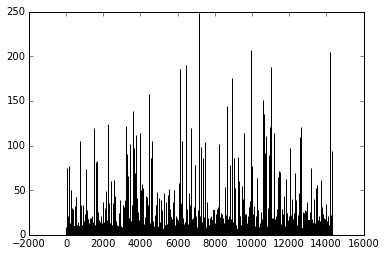

In [58]:
plt.bar(range(len(density_list)), density_list, align='center')

## Before we go any further lets get rid of data we don't need

In [59]:
for block in data_rich_geo['features']:
    block['properties'].pop('AWATER10')
    block['properties'].pop('BLOCKCE10')
    block['properties'].pop('COUNTYFP10')
    block['properties'].pop('FUNCSTAT10')
    block['properties'].pop('INTPTLAT10')
    block['properties'].pop('INTPTLON10')
    block['properties'].pop('MTFCC10')
    block['properties'].pop('STATEFP10')
    block['properties'].pop('TRACTCE10')
    block['properties'].pop('UACE10')
    block['properties'].pop('UATYP10')
    block['properties'].pop('UR10')

In [60]:
data_rich_geo['features'][0]

{u'geometry': {u'coordinates': [[[-122.761903, 45.59234],
    [-122.762954, 45.593426],
    [-122.762072, 45.593783],
    [-122.761063, 45.59274],
    [-122.761903, 45.59234]]],
  u'type': u'Polygon'},
 u'properties': {u'ALAND10': 11330.0,
  u'GEOID10': u'410510042002019',
  'HOUSEHOLDS': 15,
  'HOUSE_DENSITY': 5.357714033539276,
  u'NAME10': u'Block 2019'},
 u'type': u'Feature'}

# At  this point data is taken into Node.js to run geospatial algorithms for calculating transit coverage on each block.

The following block shows the Node.js code, using the 'turf' geospatial library, for bringing in the point locations of every transit stop and projecting a buffer radius from it based on its type (MAX stops get an 800m catchment area, other get 400m catchment area). Each buffer is compared to each block and the area of any intersection is returned. This area is added to a field on the block. The final result is that each block contains a field measuring the total area of all transit catchment overlaps.

In [74]:
# var fs = require('fs');
# var turf = require('turf');

# var polys = JSON.parse(fs.readFileSync('./data_rich_geo.json', 'utf8'));
# var points = JSON.parse(fs.readFileSync('./transit_stops.json', 'utf8'));

# var blocks = polys.features;
# var stops = points.features;

# // Initialize TRANSIT_COVERAGE field
# for(var i=0;i<blocks.length;i++){
#   var block = blocks[i];
#   block.properties.TRANSIT_COVERAGE = 0;
# }

# // Begin intersection calculations
# console.log('Starting Intersection Analysis on: '+stops.length+' transit stops');
# stops.map(LoadStop);

# function LoadStop(stop){
#   var bufferSize = stop.properties['type'] == 'MAX' ? 800 : 400;
#   var buffer = turf.buffer(stop, bufferSize, 'meters'); // project a radius from the stop based on its type
#   blocks.map( (x) => (CalcIntersection(x, buffer)) );
#   return stop;
# }

# function CalcIntersection(block,buffer){
#    // skip blocks with known self intersections
#   if((block.properties.GEOID10 == "410510059001035")||(block.properties.GEOID10 == "410510091023005")) {return block;}
#   var intersection = turf.intersect(buffer.features[0], block); // returns the intersect poly of the two features
#   if (intersection == undefined){return block;} // if the features don't intersect then undefined is returned
#   else {
#     // sum the area of intersection onto the field
#     block.properties.TRANSIT_COVERAGE = Number(block.properties.TRANSIT_COVERAGE) + Number(turf.area(intersection)); 
#     console.log(turf.area(intersection));
#     return block;
#   }
# }

# var out = JSON.stringify(polys);
# fs.writeFile('./rescoreTransit.json', out, function(err){
#   if(err) throw err;
#   console.log('All Done!');
# });


## The resulting file is then read back in

In [61]:
block_geo = ReadJSON('rescoreTransit.json')

## We calc a transit score by dividing the coverage area of the transit by the area of the block

In [62]:
def CalcScore(block):
    if block['properties']['ALAND10'] == 0:
        return 0;
    else:
        return block['properties']['TRANSIT_COVERAGE'] / block['properties']['ALAND10']

In [63]:
for block in block_geo['features']:
    block['properties']['TRANSIT_SCORE_IMP'] = CalcScore(block)

### Get the descriptive statistics for this score, so that we can effectively choose a plot range

In [64]:
transit_score = {}

for block in block_geo['features']:
    transit_score[block['properties']['GEOID10']] = block['properties']['TRANSIT_SCORE_IMP']
transit_list = transit_score.values()
print 'Mean:', np.mean(transit_list)
print 'Standard deviation:', np.std(transit_list)
print 'Minimum:', np.min(transit_list)
print 'Maximum:', np.max(transit_list)

Mean: 10.3222368406
Standard deviation: 15.8508818634
Minimum: 0.0
Maximum: 377.679769641


<Container object of 14295 artists>

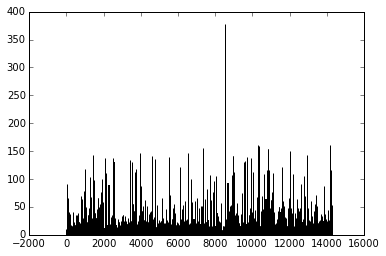

In [65]:
plt.bar(range(len(transit_list)), transit_list, align='center')

### It looks like ~40 might be a good starting point for the top end

In [66]:
# OPTIONAL - For proper scaling in the map graphic, cap the transit score at 28, 
# data goes far above this, but is not instructivly useful
for block in block_geo['features']:
    if block['properties']['TRANSIT_SCORE_IMP'] > 28:
        block['properties']['TRANSIT_SCORE_IMP'] == 28

## Now we can calculate a under-utilization score

In [67]:
def under_util_score(transit, density):
    if density == 0:
        return transit
    else:
        return transit / density

In [68]:
for block in block_geo['features']:
    block['properties']['NEW_SCORE'] = under_util_score(block['properties']['TRANSIT_SCORE_IMP'],block['properties']['HOUSE_DENSITY'])

### Again, get the descriptive stats

In [69]:
util_score = {}

for block in block_geo['features']:
    util_score[block['properties']['GEOID10']] = block['properties']['NEW_SCORE']
util_list = util_score.values()
print 'Mean:', np.mean(util_list)
print 'Standard deviation:', np.std(util_list)
print 'Minimum:', np.min(util_list)
print 'Maximum:', np.max(util_list)

Mean: 6.22517159506
Standard deviation: 23.6221101632
Minimum: 0.0
Maximum: 2007.32454282


### It looks like one value might be skewing the mean

<Container object of 14295 artists>

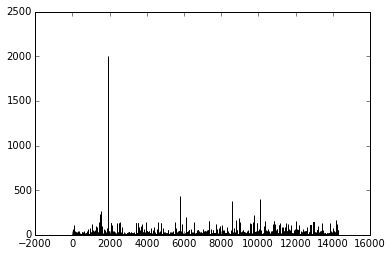

In [70]:
plt.bar(range(len(util_list)), util_list, align='center')

# The data is now exported and is ready to go for loading into mapbox

In [75]:
with open('scored_data.json', 'w') as outfile:
    json.dump(block_geo, outfile)